<a href="https://colab.research.google.com/github/Halilibrahim-Guc/Iowa-State-University-Enrollment-Prediction-/blob/main/Iowa_State_University_Enrollment_Prediction_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OrdinalEncoder

In [2]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv('/content/ISU Enrollment Data Set.zip')
df.head(71)

,Year,Semester,Ungrad,Prof,Grad,Post-Doc,Total
0,2022,Spring,24482,632,4122,0,29236
1,2021,Fall,25808,636,4264,0,30708
2,2021,Summer,6202,159,2713,0,9074
3,2021,Spring,24482,621,4265,0,29368
4,2020,Fall,26846,627,4352,0,31825
...,...,...,...,...,...,...,...
66,2000,Spring,20251,0,4082,0,24333
67,1999,Fall,21901,0,4209,0,26110
68,1999,Summer,6033,0,2858,0,8891
69,1999,Spring,19825,0,4048,0,23873


In [3]:
# Since there are many missing Post-Doc values, and Professional Promans have low enrollment, they are combined
df["Prof"] = df["Prof"] + df["Post-Doc"]
df = df.drop(['Post-Doc'], axis = 1)
df.rename(columns = {'Prof':'Prof and Post-Doc'}, inplace = True)

df.head()

,Year,Semester,Ungrad,Prof and Post-Doc,Grad,Total
0,2022,Spring,24482,632,4122,29236
1,2021,Fall,25808,636,4264,30708
2,2021,Summer,6202,159,2713,9074
3,2021,Spring,24482,621,4265,29368
4,2020,Fall,26846,627,4352,31825


In [4]:
# Encode nominal categories
enc = OrdinalEncoder()
df['Semester'] = enc.fit_transform(df[["Semester"]])

df.head()

,Year,Semester,Ungrad,Prof and Post-Doc,Grad,Total
0,2022,1.0,24482,632,4122,29236
1,2021,0.0,25808,636,4264,30708
2,2021,2.0,6202,159,2713,9074
3,2021,1.0,24482,621,4265,29368
4,2020,0.0,26846,627,4352,31825


In [5]:
# Extract the features and target variable from the DataFrame
X = df.iloc[:, :-1]
y = df[['Total']]
print(X.shape, y.shape)

(71, 5) (71, 1)


In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
)

In [8]:
# Perform cross-validation to tune the hyperparameters of our model
params = {
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [100, 200, 300, 400, 500]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eta=0.1,
                                    eval_metric=None, feature_types=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rat...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=10, max_leaves=None,
                                    min_child_weight=0.5, missing=nan,
                                    monotone_constraints=None,
                                    n_estimators=1000, n_jobs=None,
                                    num_parallel_tree=None, predictor=None, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='neg_mean_squared_error')

In [9]:
# Train the model on the training data
xgb_model = grid_search.best_estimator_
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=0.5, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [10]:
# Show the best parameters
print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500}


In [11]:
# Evaluate the performance of the model on the test data using RMSE
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % rmse)

RMSE: 414.212


In [12]:
# Calculate R-squared of regression model
R_square = r2_score(y_test, y_pred)
print('Coefficient of Determination', R_square)

Coefficient of Determination 0.9970322925432628


In [16]:
# Calculate MAE and Mape
print(mean_absolute_error(y_test, y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))

326.69895833333334
0.01250130561155746


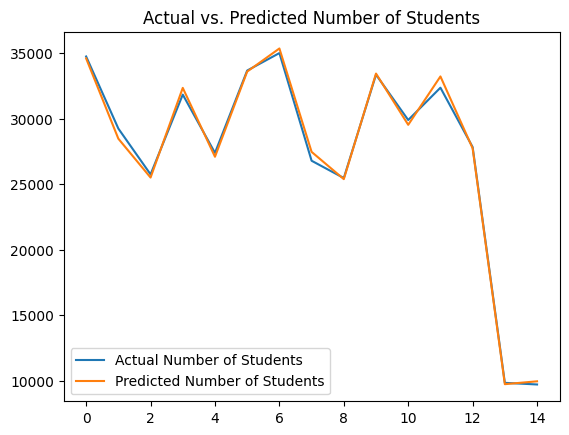

In [14]:
# Plot the predicted values against the actual values on a scatter plot
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Actual Number of Students")
plt.plot(x_ax, y_pred, label="Predicted Number of Students")
plt.title('Actual vs. Predicted Number of Students')
plt.legend()
plt.show()

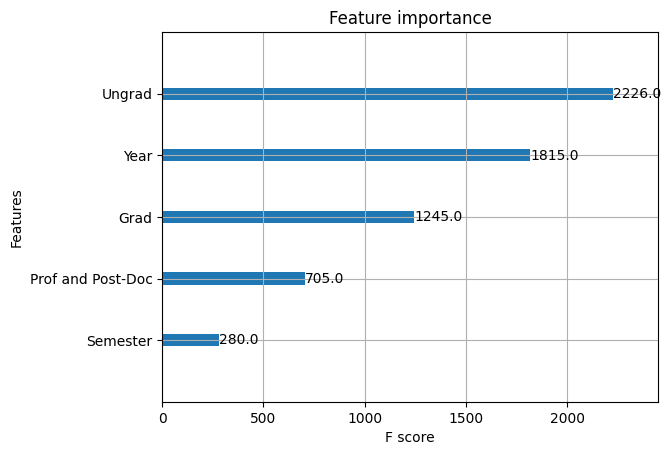

<Figure size 1600x1200 with 0 Axes>

In [15]:
# Show the feature importance
xgb.plot_importance(xgb_model)
plt.figure(figsize = (16, 12))
plt.show()